In [1]:
from skimage import color, io, measure
from skimage.measure import profile_line
from skimage.transform import rescale, resize
import matplotlib.pyplot as plt
import numpy as np
import pydicom as dicom
import seaborn as sns
import pandas as pd
from sklearn import decomposition
import math
import SimpleITK as sitk
from skimage.filters import threshold_otsu
from skimage import color
from scipy.ndimage import correlate
from skimage.filters import median
from skimage.filters import gaussian
from skimage.filters import prewitt_h
from skimage.filters import prewitt_v
from skimage.filters import prewitt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.morphology import erosion, dilation, opening, closing
from skimage.morphology import disk
from skimage.morphology import binary_closing, binary_opening
from skimage.color import label2rgb
from scipy.stats import norm
from scipy.spatial import distance
from skimage.util import img_as_float, img_as_uint
from skimage.transform import rotate
from skimage.transform import EuclideanTransform
from skimage.transform import SimilarityTransform
from skimage.transform import swirl
from skimage.transform import matrix_transform
from skimage import segmentation
import glob
from PIL import Image
from sklearn.decomposition import PCA
from skimage.transform import warp
from scipy.ndimage import binary_dilation, binary_erosion
from skimage import io, img_as_ubyte, color
from exam_functions import *

# import SimpleITK as sitk
from IPython.display import clear_output

Aquarium design using principal component analysis

Your friend has bought a new aquarium and is very excited to buy the fish that should live there.  You suggest to use image based principal component analysis (PCA) to find the optimal selection of fish. In the local fish shop, you have taken photos of 10 different types of fish:

 

("discus.jpg", "guppy.jpg", "kribensis.jpg", "neon.jpg", "oscar.jpg",  "platy.jpg", "rummy.jpg", "scalare.jpg", "tiger.jpg", "zebra.jpg")

 

First you compute an image of the average fish and then you use PCA from sklearn.decomposition to compute 6 principal components of the 10 photos. 

 

The photos of the fishes: Fish.zip

 


Your friend find the neon fish to be a personal favorite and decide to buy some of them. He also wants to have a flock of fish that are as visually different as possible from the neon fish.

You project all the fish photo on the principal components and find the fish that are furthest away from the neon fish in PCA space. Which fish should your friend choose?

400 400 3


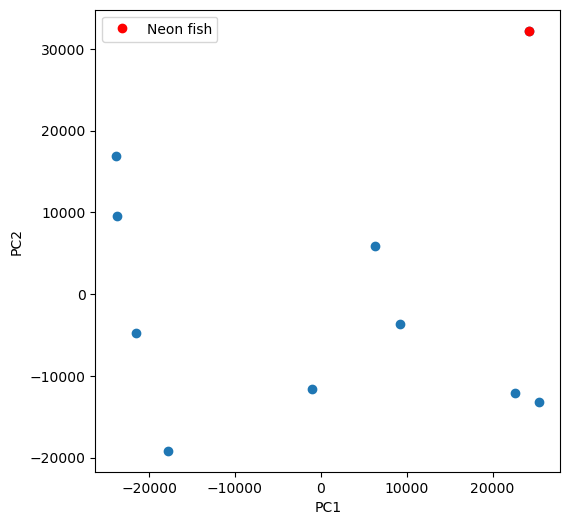

In [12]:
# 1
in_dir = r"C:\Users\Dell\Desktop\Git Hub\02502-Image-Analysis-Cheatsheet\1"

files = glob.glob(f"{in_dir}/*.jpg")

height, width, channels = io.imread(files[0]).shape
print(height, width, channels)

data_matrix = np.zeros((len(files), height * width * channels))
for i, f in enumerate(files):
    data_matrix[i, :] = io.imread(f).flatten()


average_img = np.mean(data_matrix, axis=0)
# io.imshow(create_u_byte_image_from_vector(average_img, height, width, channels))

neon = io.imread(
    r"C:\Users\Dell\Desktop\Git Hub\02502-Image-Analysis-Cheatsheet\1\neon.jpg"
)

# PCA start
pca = PCA(n_components=6)
fish_pca_model = pca.fit(data_matrix)

data_projected = fish_pca_model.transform(data_matrix)

# plot neon fish
im_miss_flat = neon.flatten()
neon_flat = im_miss_flat.reshape(1, -1)
pca_coords = fish_pca_model.transform(neon_flat)
pca_coords = pca_coords.flatten()

components = fish_pca_model.transform(data_matrix)
pc_1 = components[:, 0]
pc_2 = components[:, 1]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(pc_1, pc_2, "o")
ax.plot(pca_coords[0], pca_coords[1], "ro", label="Neon fish")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
plt.legend()
plt.show()

[15. 28. 10. ... 89. 98. 67.]


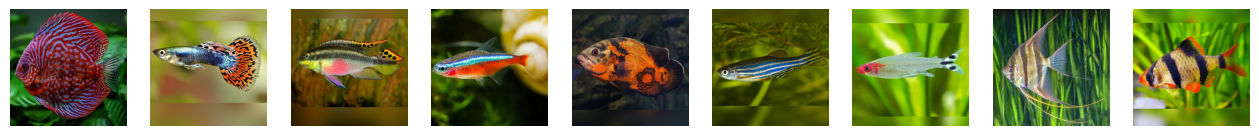

In [27]:
n_components_to_use = 6
synth_fish = average_img
for idx in range(n_components_to_use):
    synth_fish = synth_fish + pca_coords[idx] * fish_pca_model.components_[idx, :]

comp_sub = components - pca_coords
pca_distances = np.linalg.norm(comp_sub, axis=1)

# best_match = np.argmin(pca_distances)
# best_twin_fish = data_matrix[best_match, :]
worst_match = np.argmax(pca_distances)
worst_twin_fish = data_matrix[worst_match, :]

print(worst_twin_fish)

# First check
n_best = 9
best = np.argpartition(pca_distances, n_best)
fig, ax = plt.subplots(ncols=n_best, figsize=(16, 4))
for i in range(n_best):
    candidate_twin_fish = data_matrix[best[i], :]
    ax[i].imshow(
        create_u_byte_image_from_vector(candidate_twin_fish, height, width, channels)
    )
    ax[i].axis("off")

In [24]:
# second check
for i in data_matrix:
    print(i)

[28. 50. 37. ... 12. 55. 10.]
[140. 128.  46. ... 131. 119.  67.]
[93. 72.  5. ... 75. 61.  0.]
[ 3. 10.  3. ...  2.  3.  5.]
[33. 35. 32. ... 29. 42. 50.]
[15. 28. 10. ... 89. 98. 67.]
[ 99. 164.   0. ...  85. 144.   0.]
[ 13.  11.  12. ...  56. 103.  49.]
[171. 209.   0. ...  65.  91.   2.]
[67. 75.  0. ... 68. 74.  0.]


In [28]:
def nargmax(arr, n):
    # Like np.argmax but returns the n largest values
    idx = np.argpartition(arr, -n)[-n:]
    return idx[np.argsort(arr[idx])][::-1]


def nargmin(arr, n):
    # Like np.argmin but returns the n smallest values
    idx = np.argpartition(arr, n)[:n]
    return idx[np.argsort(arr[idx])]


def plot_pca_space_and_img(pc_idx):
    _, ax = plt.subplots(1, 2, figsize=(6, 3))
    ax[0].plot(pc_1, pc_2, "o")
    ax[0].plot(pc_1[pc_idx], pc_2[pc_idx], "ro", markersize=10)
    ax[0].set_xlabel("PC1")
    ax[0].set_ylabel("PC2")

    img = create_u_byte_image_from_vector(
        data_matrix[pc_idx, :], height, width, channels
    )
    ax[1].imshow(img)
    ax[1].set_title("Cat")
    ax[1].set_axis_off()
    plt.show()

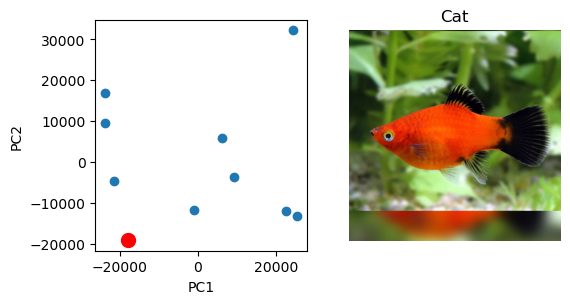

In [31]:
# Third check
max_pc1s = nargmin(pc_2, 1)
for i in max_pc1s:
    plot_pca_space_and_img(i)

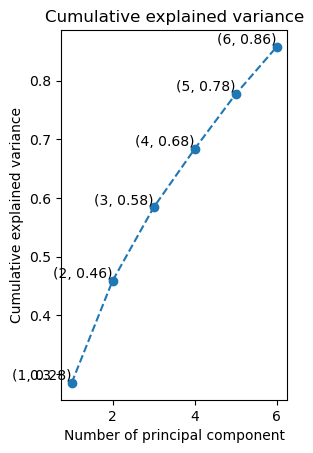

In [33]:
values_pca = pca.explained_variance_
exp_var_ratio = pca.explained_variance_ratio_
vectors_pca = pca.components_  # vector of the principal components

pc1 = fish_pca_model.components_[0]
pc2 = fish_pca_model.components_[1]

plt.subplot(1, 2, 2)
plt.plot(
    range(1, len(exp_var_ratio) + 1),
    np.cumsum(exp_var_ratio),
    marker="o",
    linestyle="--",
)
plt.xlabel("Number of principal component")
plt.ylabel("Cumulative explained variance")
plt.title("Cumulative explained variance")

# Aggiunta dei valori dei punti nel grafico
for i, (x, y) in enumerate(
    zip(range(1, len(exp_var_ratio) + 1), np.cumsum(exp_var_ratio))
):
    plt.text(x, y, f"({x}, {y:.2f})", ha="right", va="bottom")

# Mostra il grafico
plt.show()

Your friend really likes the look of the neon fish and the guppy. 

To get an idea of how visually different they are, you compute the pixelwise sum of squared differences between the photo of the neon fish and the guppy. 

What is this value? 

In [39]:
guppy = io.imread(
    r"C:\Users\Dell\Desktop\Git Hub\02502-Image-Analysis-Cheatsheet\1\guppy.jpg"
)

s = np.sum((neon[:, :, 0:3] - guppy[:, :, 0:3]) ** 2)
s

49587814

49'587'814

To remove redundancy in the data, a principal component analysis (PCA) is performed. Since the measurements are of very different scales, they are scales using the standard deviation before the PCA:

 

1) Load the data from the pistachio_data.txt file

2) Subtract the mean from the data

3) Compute the standard deviation of each measurement (for example the standard deviation of the AREA).

4) Divide each measurement by its own standard deviation.

5) Do the PCA



Number of features: 12 and number of observations: 200
159190463.4289196
97447.54612674122
1520.101168102561
578.6932351032098
0.001006955151758794
757.2127319337284
0.0022559502690954777
152625904.1471357
0.0027684353706030145
0.044887380964572864
0.03404414823718593
0.001074479757788945
The maximum absolute value in the covariance matrix is: 1.005025125628141


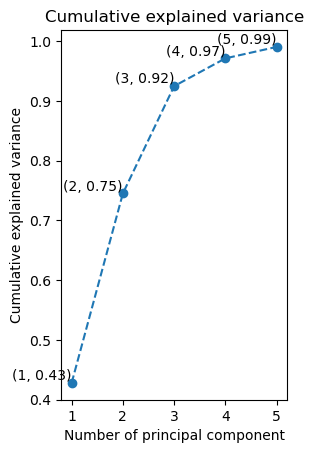

In [66]:
# 2

# load txt dataset
txt_name = r"C:\Users\Dell\Desktop\Git Hub\02502-Image-Analysis-Cheatsheet\2\pistachio_data.txt"
pistacchio_data = np.loadtxt(txt_name, comments="%")

# x is a matrix with 50 rows and 4 columns
x = pistacchio_data[0:, 0:]
n_feat = x.shape[1]
n_obs = x.shape[0]
print(f"Number of features: {n_feat} and number of observations: {n_obs}")

# subtract mean
x_std = x - np.mean(x, axis=0)

# compute variance for each feature

area = x_std[:, 0]
var_area = area.var(ddof=1)
perim = x_std[:, 1]
var_perim = perim.var(ddof=1)
max_ax = x_std[:, 2]
var_max_ax = max_ax.var(ddof=1)
min_ax = x_std[:, 3]
var_min_ax = min_ax.var(ddof=1)
ecc = x_std[:, 4]
var_ecc = ecc.var(ddof=1)
eqd = x_std[:, 5]
var_eqd = eqd.var(ddof=1)
solidity = x_std[:, 6]
var_solidity = solidity.var(ddof=1)
convex = x_std[:, 7]
var_convex = convex.var(ddof=1)
extent = x_std[:, 8]
var_extent = extent.var(ddof=1)
aspc_rat = x_std[:, 9]
var_aspc_rat = aspc_rat.var(ddof=1)
roundness = x_std[:, 10]
var_roundness = roundness.var(ddof=1)
compact = x_std[:, 11]
var_compact = compact.var(ddof=1)

print(var_area)
print(var_perim)
print(var_max_ax)
print(var_min_ax)
print(var_ecc)
print(var_eqd)
print(var_solidity)
print(var_convex)
print(var_extent)
print(var_aspc_rat)
print(var_roundness)
print(var_compact)

x_std = x_std / np.std(x, axis=0)

# display matrix of scatterplots of pair of features.
plt.figure()  # Added this to make sure that the figure appear

# Compute the covariance matrix
cov_matrix = np.cov(x_std.T)
# Transpose the data to compute the covariance matrix properly

# Find the maximum absolute value in the covariance matrix
max_abs_value = np.max(np.abs(cov_matrix))

print(f"The maximum absolute value in the covariance matrix is: {max_abs_value}")

# perform PCA
data = x_std  # deve essere di tipo numpy, non gli va bene un panda dataframe
pca = decomposition.PCA(n_components=5)
pca_model = pca.fit(data)

values_pca = pca.explained_variance_
exp_var_ratio = pca.explained_variance_ratio_
vectors_pca = pca.components_  # vector of the principal components

pc1 = pca_model.components_[0]
pc2 = pca_model.components_[1]

plt.subplot(1, 2, 2)
plt.plot(
    range(1, len(exp_var_ratio) + 1),
    np.cumsum(exp_var_ratio),
    marker="o",
    linestyle="--",
)
plt.xlabel("Number of principal component")
plt.ylabel("Cumulative explained variance")
plt.title("Cumulative explained variance")

# Aggiunta dei valori dei punti nel grafico
for i, (x, y) in enumerate(
    zip(range(1, len(exp_var_ratio) + 1), np.cumsum(exp_var_ratio))
):
    plt.text(x, y, f"({x}, {y:.2f})", ha="right", va="bottom")

# Mostra il grafico
plt.show()

In [224]:
m = [
    159190463.4289196,
    97447.54612674122,
    1520.101168102561,
    578.6932351032098,
    0.001006955151758794,
    757.2127319337284,
    0.0022559502690954777,
    152625904.1471357,
    0.0027684353706030145,
    0.044887380964572864,
    0.03404414823718593,
    0.001074479757788945,
]
min(m)

0.001006955151758794

To find out how far away from normal a pistachio nut is, we can look at position of the nut in PCA space. 

We start by projecting the measurements of the first nut onto the principal components. 

The sum of squared projected values are now computed since they give a measure of how far away from the origin the nut is.

 What is the sum of squared projected values?

In [55]:
first_nut = x_std[0, :]

projection = pca_model.transform(x_std)

# 'projection' now contains the projection of the first nut onto the principal components
print("Projection of the first nut onto principal components:")
print(projection)

Projection of the first nut onto principal components:
[[ 7.16937684e-01  4.21513176e+00 -8.81947674e-01  6.30994065e-01
  -7.36753779e-02]
 [ 1.78429191e-01  3.77008839e+00  3.70210289e-01 -7.05507203e-01
  -6.57403292e-02]
 [-6.62394216e-02 -3.05896885e-01  3.36405958e-01  4.60815277e-01
   4.72265560e-01]
 [ 2.94172284e-01  5.08780484e-01 -1.40674397e-01 -5.20595964e-01
  -7.07138622e-01]
 [-1.00776584e+00 -1.34024089e+00  2.72829460e-01 -1.25660852e-01
   9.10978897e-02]
 [ 3.79006500e+00  1.77218815e+00 -7.93057305e-02  2.20150839e+00
  -3.62009009e-01]
 [-1.32227756e+00  4.46331273e+00 -2.62670067e+00  2.43175492e-01
  -4.02114001e-01]
 [ 1.27446668e+00  3.66707122e+00 -3.68587695e-01 -1.01286809e+00
  -5.99545614e-01]
 [ 1.76371127e+00  2.07967534e+00  2.44248491e+00 -6.80919632e-01
   1.35284781e-01]
 [ 4.15539490e-02 -2.62196643e+00  1.76682317e+00  2.33547803e-01
  -3.25867668e-02]
 [ 6.80502711e-01  2.85435081e+00  1.27142469e+00 -3.33956101e-01
  -8.89784947e-01]
 [ 1.67231

In [56]:
(
    (7.16937684e-01) ** 2
    + (4.21513176e00) ** 2
    + (-8.81947674e-01) ** 2
    + (6.30994065e-01) ** 2
    + (-7.36753779e-02) ** 2
)

19.462748667947928

![
](attachment:image.png)

You can use the function “array = sitk.GetArrayFromImage(sitkImage)” to get a numpy array from a SimpleITK image object. 

After creating a sitk.AffineTransform(3) object, you can manually set up a translation using the function transform.SetTranslation(…).

In [172]:
def imshow_orthogonal_view(sitkImage, origin=None, title=None):
    """
    Display the orthogonal views of a 3D volume from the middle of the volume.

    Parameters
    ----------
    sitkImage : SimpleITK image
        Image to display.
    origin : array_like, optional
        Origin of the orthogonal views, represented by a point [x,y,z].
        If None, the middle of the volume is used.
    title : str, optional
        Super title of the figure.

    Note:
    On the axial and coronal views, patient's left is on the right
    On the sagittal view, patient's anterior is on the left
    """
    data = sitk.GetArrayFromImage(sitkImage)

    if origin is None:
        origin = np.array(data.shape) // 2

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    data = img_as_ubyte(data / np.max(data))
    axes[0].imshow(data[origin[0], ::-1, ::-1], cmap="gray")
    axes[0].set_title("Axial")

    axes[1].imshow(data[::-1, origin[1], ::-1], cmap="gray")
    axes[1].set_title("Coronal")

    axes[2].imshow(data[::-1, ::-1, origin[2]], cmap="gray")
    axes[2].set_title("Sagittal")

    [ax.set_axis_off() for ax in axes]

    if title is not None:
        fig.suptitle(title, fontsize=16)


def overlay_slices(sitkImage0, sitkImage1, origin=None, title=None):
    """
    Overlay the orthogonal views of a two 3D volume from the middle of the volume.
    The two volumes must have the same shape. The first volume is displayed in red,
    the second in green.

    Parameters
    ----------
    sitkImage0 : SimpleITK image
        Image to display in red.
    sitkImage1 : SimpleITK image
        Image to display in green.
    origin : array_like, optional
        Origin of the orthogonal views, represented by a point [x,y,z].
        If None, the middle of the volume is used.
    title : str, optional
        Super title of the figure.

    Note:
    On the axial and coronal views, patient's left is on the right
    On the sagittal view, patient's anterior is on the left
    """
    vol0 = sitk.GetArrayFromImage(sitkImage0)
    vol1 = sitk.GetArrayFromImage(sitkImage1)

    if vol0.shape != vol1.shape:
        raise ValueError("The two volumes must have the same shape.")
    if (
        np.min(vol0) < 0 or np.min(vol1) < 0
    ):  # Remove negative values - Relevant for the noisy images
        vol0[vol0 < 0] = 0
        vol1[vol1 < 0] = 0
    if origin is None:
        origin = np.array(vol0.shape) // 2

    sh = vol0.shape
    R = img_as_ubyte(vol0 / np.max(vol0))
    G = img_as_ubyte(vol1 / np.max(vol1))

    vol_rgb = np.zeros(shape=(sh[0], sh[1], sh[2], 3), dtype=np.uint8)
    vol_rgb[:, :, :, 0] = R
    vol_rgb[:, :, :, 1] = G

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(vol_rgb[origin[0], ::-1, ::-1, :])
    axes[0].set_title("Axial")

    axes[1].imshow(vol_rgb[::-1, origin[1], ::-1, :])
    axes[1].set_title("Coronal")

    axes[2].imshow(vol_rgb[::-1, ::-1, origin[2], :])
    axes[2].set_title("Sagittal")

    [ax.set_axis_off() for ax in axes]

    if title is not None:
        fig.suptitle(title, fontsize=16)


# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations

    metric_values = []
    multires_iterations = []


# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations

    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()


# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations

    metric_values.append(registration_method.GetMetricValue())
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, "r")
    plt.plot(
        multires_iterations,
        [metric_values[index] for index in multires_iterations],
        "b*",
    )
    plt.xlabel("Iteration Number", fontsize=12)
    plt.ylabel("Metric Value", fontsize=12)
    plt.show()


# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the
# metric_values list.
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))


def command_iteration(method):
    print(
        f"{method.GetOptimizerIteration():3} "
        + f"= {method.GetMetricValue():10.5f} "
        + f": {method.GetOptimizerPosition()}"
    )

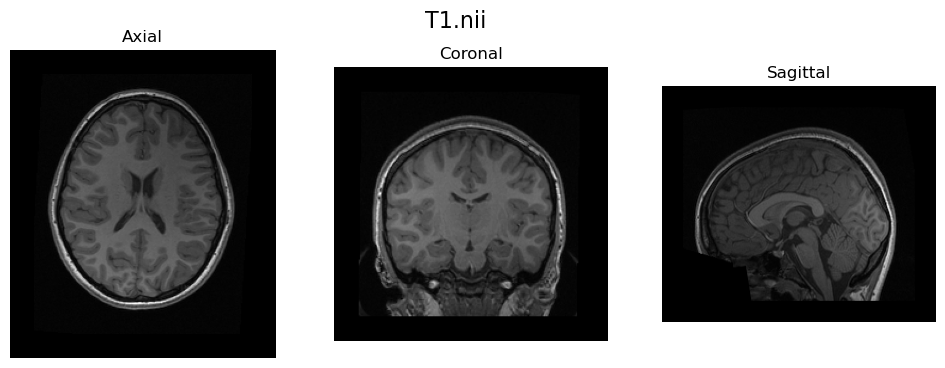

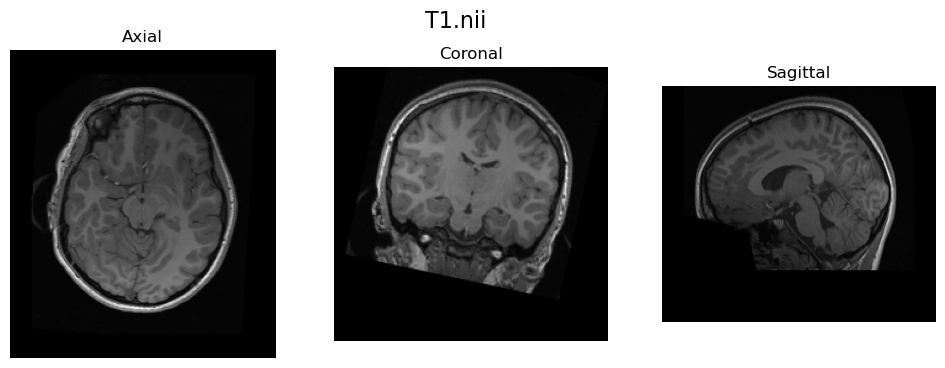

In [174]:
# 4

vol_sitk1 = sitk.ReadImage(
    r"C:\Users\Dell\Desktop\Git Hub\02502-Image-Analysis-Cheatsheet\4\ImgT1_v1.nii"
)
vol_sitk2 = sitk.ReadImage(
    r"C:\Users\Dell\Desktop\Git Hub\02502-Image-Analysis-Cheatsheet\4\ImgT1_v2.nii"
)

# Display the volume

imshow_orthogonal_view(vol_sitk1, title="T1.nii")
imshow_orthogonal_view(vol_sitk2, title="T1.nii")

In [175]:
def rotation_matrix(pitch, roll, yaw):
    """
    Returns the rotation matrix for given roll, pitch, and yaw angles.
    """
    cos_pitch = np.cos(pitch)
    sin_pitch = np.sin(pitch)
    cos_roll = np.cos(roll)
    sin_roll = np.sin(roll)
    cos_yaw = np.cos(yaw)
    sin_yaw = np.sin(yaw)

    # Define the rotation matrix for pitch, roll, and yaw
    R_pitch = np.array(
        [[1, 0, 0], [0, cos_pitch, -sin_pitch], [0, sin_pitch, cos_pitch]],
    )

    R_roll = np.array([[cos_roll, 0, sin_roll], [0, 1, 0], [-sin_roll, 0, cos_roll]])

    R_yaw = np.array([[cos_yaw, -sin_yaw, 0], [sin_yaw, cos_yaw, 0], [0, 0, 1]])

    # Combine the rotation matrices to obtain the final rotation matrix
    rotation_matrix = np.dot(R_yaw, np.dot(R_pitch, R_roll))
    return rotation_matrix

4x4 Affine Matrix with a roll -20 degrees:
[[ 0.93969262  0.          0.34202014  0.        ]
 [ 0.          1.          0.          0.        ]
 [-0.34202014  0.          0.93969262  0.        ]
 [ 0.          0.          0.          1.        ]]


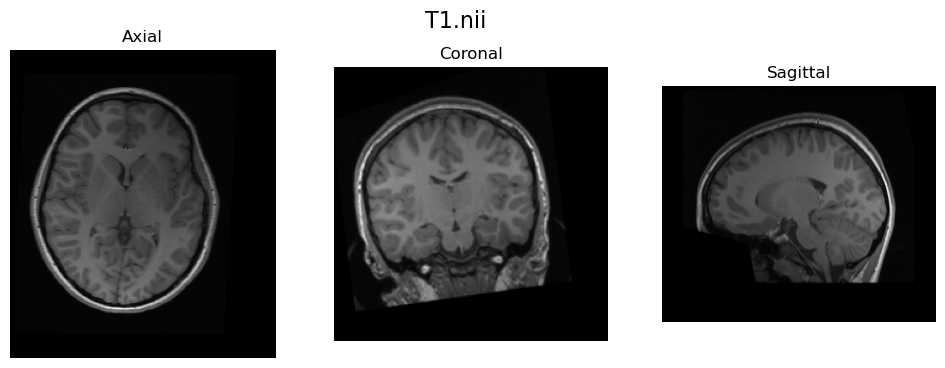

In [181]:
# Convert degrees to radians for the roll angle

roll_deg = 20
roll_rad = np.radians(roll_deg)

# Get the rotation matrix for the given roll angle and zero roll and yaw
affine_matrix = np.eye(4)
affine_matrix[:3, :3] = rotation_matrix(0, roll_rad, 0)

print("4x4 Affine Matrix with a roll -20 degrees:")
print(affine_matrix)

# Create an affine transform
transform = sitk.AffineTransform(3)  # 3D transformation

# Set the rotation matrix to the affine transform
transform.SetMatrix(rotation_matrix(0, roll_rad, 0).flatten())

# Apply the transformation to the image
rotated_image = sitk.Resample(vol_sitk2, transform)

# Save the rotated image
# sitk.WriteImage(rotated_image, "./4/vol_sitk2_rotated.nii")
imshow_orthogonal_view(rotated_image, title="T1.nii")

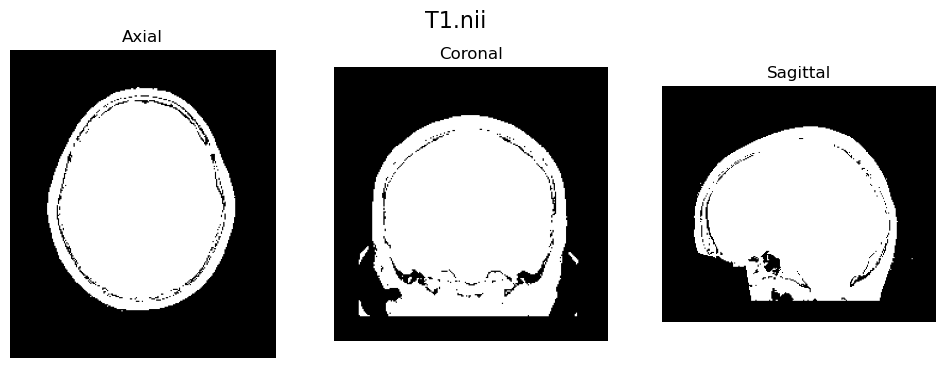

In [183]:
threshold_value = 50
brain_mask = vol_sitk1 > threshold_value

# Convert the mask to an integer image
brain_mask_int = sitk.Cast(brain_mask, sitk.sitkUInt8)

imshow_orthogonal_view(brain_mask, title="T1.nii")

In [185]:
# Convert images to Numpy arrays
original_arr = sitk.GetArrayFromImage(vol_sitk1)
reconstructed_arr = sitk.GetArrayFromImage(rotated_image)

mask_arr = sitk.GetArrayFromImage(brain_mask)

# Apply the mask to both original and reconstructed images
masked_original = np.where(mask_arr > 0, original_arr, 0)
masked_reconstructed = np.where(mask_arr > 0, reconstructed_arr, 0)

# Compute MSE within the brain mask
mse = np.mean((original_arr - reconstructed_arr) ** 2)
print(f"Mean Squared Error within brain mask: {mse}")

Mean Squared Error within brain mask: 12708.6767578125


In [196]:
# Esempio di trasformazioni
# L'ordine è importante
transformations = [
    ("rotation", (45, -30, 10)),  # Rotazione (x=pitch, y=roll, z=yaw)
    ("translation", (10, 5, 3)),  # Traslazione
    ("scaling", (1.5, 2, 1)),  # Scalatura
    ("shearing", (0.2, 0.1, 0.3, 0.1, 0.4, 0.2)),  # Shearing
]

# Creazione della matrice di trasformazione affine
affine_matrix = create_affine_matrix(transformations)
# Stampare la matrice risultante
print(affine_matrix)

[[ 1.23624206  0.14102469 -0.93371173 17.3       ]
 [-0.0199008   1.51134064 -1.38850763 14.8       ]
 [ 0.89253332  0.84784336  0.06742346 11.        ]
 [ 0.          0.          0.          1.        ]]


In [201]:
import numpy as np

# La tua matrice di trasformazione 4x4
transform_matrix = np.array(
    [[0.98, -0.16, 0.17, 0], [0.26, 0.97, 0, -15], [-0.17, 0.04, 0.98, 0], [0, 0, 0, 1]]
)

# Estrai la parte di rotazione (prime tre righe e colonne)
rotation_matrix = transform_matrix[:3, :3]

# Estrai la parte di traslazione (prime tre righe, ultima colonna)
translation_vector = transform_matrix[:3, 3]

# Calcola la scala
scale = np.linalg.norm(rotation_matrix, axis=0)

# Output dei risultati
print("Matrice di rotazione:")
print(rotation_matrix)
print("\nVettore di traslazione:")
print(translation_vector)
print("\nScala:")
print(scale)

Matrice di rotazione:
[[ 0.98 -0.16  0.17]
 [ 0.26  0.97  0.  ]
 [-0.17  0.04  0.98]]

Vettore di traslazione:
[  0. -15.   0.]

Scala:
[1.02805642 0.98392073 0.99463561]


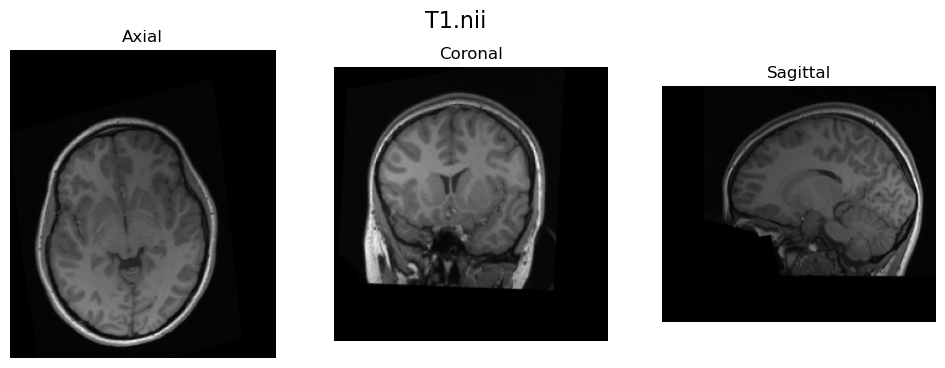

In [211]:
# Definisci la matrice di trasformazione 4x4
transform_matrix = np.array(
    [[0.98, -0.16, 0.17, 0], [0.26, 0.97, 0, -15], [-0.17, 0.04, 0.98, 0], [0, 0, 0, 1]]
)

# Estrai i componenti di traslazione, rotazione e scala dalla matrice
translation = transform_matrix[0:3, 3]  # Primi 3 valori dell'ultima colonna
rotation_scale = transform_matrix[0:3, 0:3]  # Primi 3x3 valori della matrice

# Crea la trasformazione affine
affine_transform = sitk.AffineTransform(3)  # 3 per dimensioni 3D
affine_transform.SetMatrix(
    rotation_scale.flatten()
)  # Imposta la parte di rotazione e scala
affine_transform.SetTranslation(translation)  # Imposta la parte di traslazione

# Applica la trasformazione all'immagine
# image = sitk.ReadImage("percorso_all_immagine.nii")
transformed_image = sitk.Resample(vol_sitk2, affine_transform)

# Salva l'immagine trasformata
# sitk.WriteImage(transformed_image, "immagine_trasformata.nii")

imshow_orthogonal_view(transformed_image, title="T1.nii", origin=None)

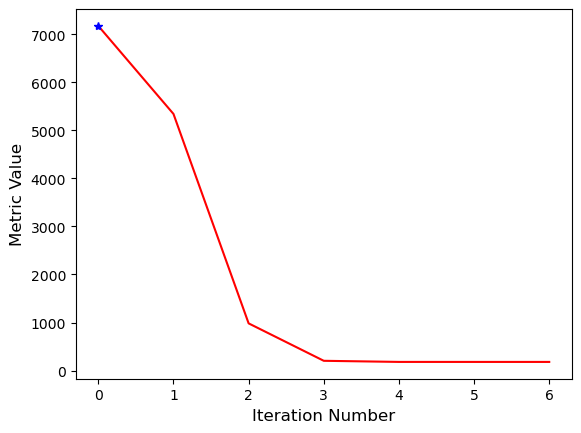

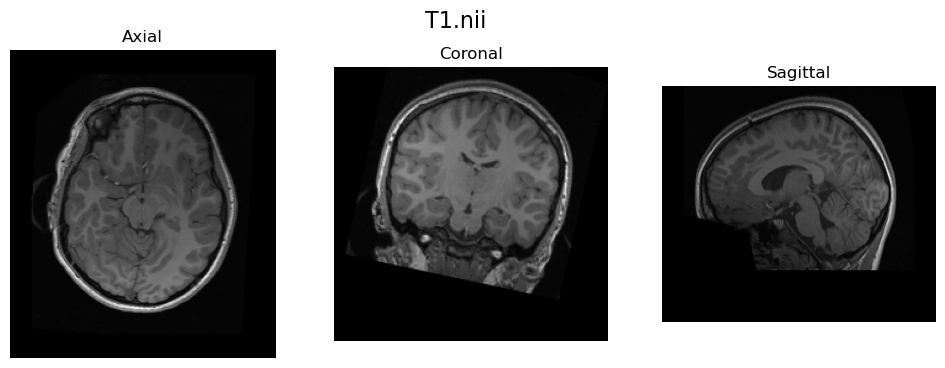

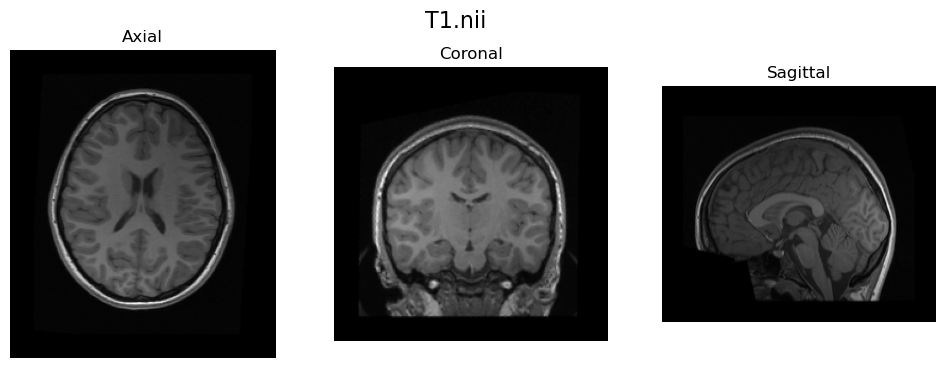

In [236]:
# Set the registration - Fig. 1 from the Theory Note
R = sitk.ImageRegistrationMethod()

# Set a one-level the pyramid scheule. [Pyramid step]
R.SetShrinkFactorsPerLevel(shrinkFactors=[5])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the interpolator [Interpolation step]
R.SetInterpolator(sitk.sitkLinear)

# Set the similarity metric [Metric step]
R.SetMetricAsMeanSquares()

# Set the sampling strategy [Sampling step]
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.50)

# Set the optimizer [Optimization step]
R.SetOptimizerAsPowell(stepLength=0.1, numberOfIterations=25)


# Initialize the transformation type to rigid
# initTransform = sitk.Euler3DTransform()
# Change the rotation center to the center of the image
initTransform = sitk.CenteredTransformInitializer(
    vol_sitk1,
    vol_sitk2,
    sitk.Euler3DTransform(),
    sitk.CenteredTransformInitializerFilter.GEOMETRY,
)
R.SetInitialTransform(initTransform, inPlace=False)

# Some extra functions to keep track to the optimization process
# R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R)) # Print the iteration number and metric value
R.AddCommand(
    sitk.sitkStartEvent, start_plot
)  # Plot the similarity metric values across iterations
R.AddCommand(sitk.sitkEndEvent, end_plot)
R.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations)
R.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(R))


# Estimate the registration transformation [metric, optimizer, transform]
tform_reg = R.Execute(vol_sitk1, vol_sitk2)

# Apply the estimated transformation to the moving image
vol_sitk2_TR = sitk.Resample(vol_sitk2, tform_reg)

imshow_orthogonal_view(vol_sitk2, title="T1.nii", origin=None)
imshow_orthogonal_view(vol_sitk2_TR, title="T1.nii", origin=None)
# Save
# sitk.WriteImage(ImgT1_B, dir_in + "ImgT1_B.nii")

In [244]:
t = sitk.ReadTransform(tform_reg)

TypeError: in method 'ReadTransform', argument 1 of type 'std::string const &'

Heart analysis on computed tomography scans

A radiologist has asked you for help to assess the function of the heart as seen on a computed tomography scan. The main interest is the heart muscle (myocardium) and the blood inside the myocardium (blood).

 We try first on a single DICOM slice (1-001.dcm), where we also have some manual annotations. We have a region-of-interest (ROI) in the myocardium (MyocardiumROI.png), a region-of-interest in the blood (bloodROI.png) and a full ground truth annotation of the blood (bloodGT.png). 

 

Our initial analysis consist of:

1) Read the DICOM file and get the pixel values (as Hounsfield units).
2) Extract the pixel values of the ROI of the myocardium and the blood using the manual annotations.

In [3]:
# 5

dcm = dicom.read_file(r"5\1-001.dcm")
im = dcm.pixel_array
myocardium_roi = io.imread(r"5\MyocardiumROI.png")
blood_roi = io.imread(r"5\BloodROI.png")
blood_GT = io.imread(r"5\BloodGT.png")

myoca_mask = myocardium_roi > 0
blood_mask = blood_roi > 0
blood_GT_mask = blood_GT > 0

# pixel values
myoca_val = im[myoca_mask]
blood_val = im[blood_mask]
blood_GT_val = im[blood_GT_mask]

myoca_mu = np.mean(myoca_val)
blood_mu = np.mean(blood_val)
blood_std = np.std(blood_val)
blood_GT_mu = np.mean(blood_GT_val)

print(myoca_mu, blood_mu, blood_GT_mu)

104.0374531835206 252.7867575462512 235.25401662049862


To make an automatic segmentation of the blood, the average Hounsfield unit value (
μ
) and the standard deviation (
σ
) of the Hounsfield units in the blood are computed using the manual annotations.

 

A class range is computed, so all pixels with:

In [4]:
t1 = blood_mu - 3 * blood_std
t2 = blood_mu + 3 * blood_std

img_bin = (im > t1) & (im < t2)
print(f"t1 : {t1}, t2: {t2}")

t1 : 209.98726921194577, t2: 295.58624588055665


To clean the binary image, a morphological closing with disk shaped structuring element of radius 3 is performed followed by a morphological opening with a structuring element of radius 5.  

A BLOB analysis is performed on the resulting image and the area of all the BLOBs are computed.  

The BLOBs are filtered so only BLOBs with an area larger than 2000 pixels and an area less than 5000 pixels are kept. 

Number of labels: 5
Number of labels after filtering: 1


c:\Users\Dell\anaconda3\envs\course02502\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


DICE score 0.9375729288214703


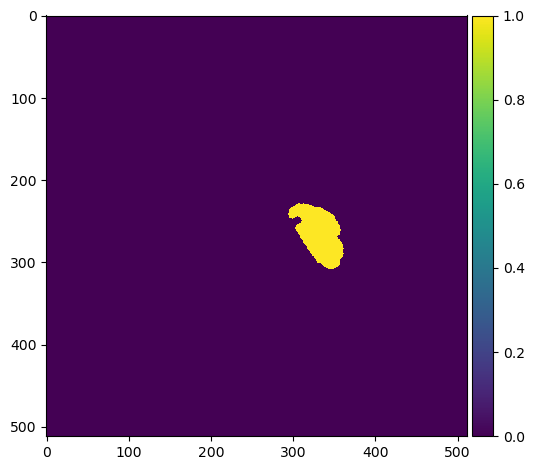

In [9]:
footprint = disk(3)
closed = closing(img_bin, footprint)

footprint = disk(5)
opened = opening(closed, footprint)

min_area = 2000
max_area = 5000

label_img = measure.label(opened)
n_labels = label_img.max()
print(f"Number of labels: {n_labels}")

region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])

# Create a copy of the label_img
label_img_filter = label_img.copy()
for region in region_props:
    # Find the areas that do not fit our criteria
    crit1 = region.area < min_area
    crit2 = region.area > max_area
    if crit1 or crit2:
        # set the pixels in the invalid areas to background
        for cords in region.coords:
            label_img_filter[cords[0], cords[1]] = 0

label_img = measure.label(label_img_filter)
n_labels = label_img.max()
print(f"Number of labels after filtering: {n_labels}")


io.imshow(label_img)

gt_bin = resize(blood_GT, label_img.shape)
dice_score = 1 - distance.dice(label_img.ravel(), gt_bin.ravel())
print(f"DICE score {dice_score}")

To be able to do a pixelwise classification, we would like to use a minimum-distance classifier to seperate the myocardium and the blood. 

What is the class limit between the two, when using a minimum-distance classifier?

In [108]:
minimum_distance_classifier([104.0374531835206, 252.7867575462512])

104.0374531835206 - mean = 104.037
252.7867575462512 - mean = 252.787

{'(104.037, 252.787)': 178.412}


{'(104.037, 252.787)': 178.412}

The dots representing the endpoints of the sticks i.e. the head, arms, and feet have changed position (in the running person) compared to the positions in standing person. We use the dots as landmarks to find the 2D registration that brings the landmarks from the template (the running person) over in the reference (the standing person).

 

We use a sum-of-squared-distances objective function to first compute how well the landmarks are aligned before any transformation.

 

Secondly, we compute the optimal translation (ΔX, Δy) that aligns the two sets of landmarks.

 

Finally, we try a similarity transform (translation, scaling and rotation) to align the two sets of landmarks.

In [123]:
def similarity_transformation1(src, dst):
    # dst_img = moving_img
    # src_img = fixed_img

    e_x = src[:, 0] - dst[:, 0]
    error_x = np.dot(e_x, e_x)
    e_y = src[:, 1] - dst[:, 1]
    error_y = np.dot(e_y, e_y)
    f = error_x + error_y
    print(f"Landmark alignment error F (sum of squared differences): {f}")

    tform = SimilarityTransform()
    tform.estimate(src, dst)
    tform.scale_params = True
    src_transform = matrix_transform(src, tform.params)
    print(src_transform)

    e_x = src_transform[:, 0] - dst[:, 0]
    error_x = np.dot(e_x, e_x)
    e_y = src_transform[:, 1] - dst[:, 1]
    error_y = np.dot(e_y, e_y)
    f_after = error_x + error_y
    print(f"Aligned landmark alignment error F: {f_after}")
    print(f"Answer: alignment error change: {f - f_after:.0f}")

    # _, ax = plt.subplots()
    # io.imshow(src_img)
    # ax.plot(
    #     src_transform[:, 0],
    #     src_transform[:, 1],
    #     "-r",
    #     markersize=12,
    #     label="Source transform",
    # )
    # ax.plot(dst[:, 0], dst[:, 1], "-g", markersize=12, label="Destination")
    # ax.invert_yaxis()
    # ax.legend()
    # ax.set_title("Landmarks after alignment")
    # plt.show()

    # warped = warp(src_img, tform.inverse)
    # show_comparison(dst_img, warped, "Landmark based transformation")
    # warped = img_as_ubyte(warped)
    return tform

In [124]:
# 6

src = np.array([[1, 0], [5, 0], [2, 4], [4, 4], [3, 6]])
dst = np.array([[3, 1], [7, 1], [3.5, 3], [5.5, 5], [4.5, 6]])

tform = similarity_transformation1(src, dst)
np.degrees(tform.rotation)

Landmark alignment error F (sum of squared differences): 18.75
[[3.33505155 0.55670103]
 [6.75773196 1.05154639]
 [3.69587629 4.10309278]
 [5.40721649 4.35051546]
 [4.30412371 5.93814433]]
Aligned landmark alignment error F: 2.097938144329895
Answer: alignment error change: 17


8.226722464108176

In [135]:
from skimage.transform import estimate_transform

displacements = src - dst

# Calculate the mean displacement vector
mean_translation = np.mean(displacements, axis=0)

print("Optimal Translation Vector:", mean_translation)

Optimal Translation Vector: [-1.7 -0.4]


Pixelwise operations

You have taken a photo from your last holidays and you would like to see if you enhance or modify the appearance of this photo. For this you are experimenting with some pixelwise operations. You do:

 

1. Load the image as an RGB image.
2. Convert the image to gray scale. Now the image is a floating point image where the values are in the range of [0, 1].
3. Do a linear gray scale histogram stretch. The new image should have a minimum value of 0.2 and a maximum value of 0.8.
4. Computing the average value of the histogram stretched image.
5. Use the prewitt_h filter to extract edges in the image.
6. Computing the maximum absolute value of the Prewitt filtered image.
7. Creating a binary image from the histogram stretched image by using a threshold with a value that is equal to the average value of the image.
8. Computing the number of foreground pixels in the binary image.

In [137]:
# 7
river = io.imread(
    r"C:\Users\Dell\Desktop\Git Hub\02502-Image-Analysis-Cheatsheet\7\ardeche_river.jpg"
)

river_gray = color.rgb2gray(river)
river_stretched = histogram_stretch(river_gray, 0.2, 0.8)
avg_img = np.mean(river_stretched)
print(avg_img)
img_h = prewitt_h(river_stretched)

max_abs = np.max(np.abs(img_h))
print(max_abs)

img_tresh = river_stretched > avg_img

# count instances true values
valori_unici, conteggi = np.unique(np.array(img_tresh), return_counts=True)

# Stampa i risultati
for valore, conteggio in zip(valori_unici, conteggi):
    print(f"Valore: {valore}, Numero di istanze: {conteggio}")

0.4763035761289877
0.5348138823529411
Valore: False, Numero di istanze: 265443
Valore: True, Numero di istanze: 244957


In [9]:
# 8

Your first version of the system is working like this:

You have two images: frame_1.jpg and frame_2.jpg

After reading the images you convert them to the HSV color space using rgb2hsv

You extract the S channel of both the HSV images and scale the channel with 255

 You compute the absolute difference image between the two S images

You compute the average value and the standard deviation of the values in the difference image

You compute a threshold as the average value plus two times the standard deviation

You compute a binary change image by setting all pixel in the difference image that are higher than the threshold to foreground (1) and 
the rest of the pixels to background (0)

You compute the number of changed pixels

You perform a BLOB analysis on the binary change image

You find the BLOB with the largest area

In [142]:
# 9
frame1 = io.imread(r"9\frame_1.jpg")
frame2 = io.imread(r"9\frame_2.jpg")

hsv_img1 = color.rgb2hsv(frame1)
s_img1 = hsv_img1[:, :, 1]
s_img1_s = s_img1 * 255

hsv_img2 = color.rgb2hsv(frame2)
s_img2 = hsv_img2[:, :, 1]
s_img2_s = s_img2 * 255

abs_diff_img = np.abs(s_img1_s - s_img2_s)

avg_value = np.mean(abs_diff_img)

std_value = np.std(abs_diff_img)

t = avg_value + 2 * std_value

print(t)

img_tresh = abs_diff_img > t

# count instances true values
# Conta le istanze di valori unici
valori_unici, conteggi = np.unique(np.array(img_tresh), return_counts=True)

# Stampa i risultati
for valore, conteggio in zip(valori_unici, conteggi):
    print(f"Valore: {valore}, Numero di istanze: {conteggio}")

label_img = measure.label(img_tresh)
n_labels = label_img.max()
print(f"Number of labels: {n_labels}")

region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])

print(np.max(areas))

83.16702036658369
Valore: False, Numero di istanze: 282380
Valore: True, Numero di istanze: 24820
Number of labels: 424
10290


In [11]:
# 10

In [12]:
# 11

In [13]:
# 12

In [15]:
# 13

In [16]:
# 14

In [17]:
# 15

In [18]:
# 16

In [19]:
# 17

In [20]:
# 18

In [21]:
# 19

In [22]:
# 20

In [23]:
# 21

In [24]:
# 22

In [25]:
# 23

In [26]:
# 24

In [27]:
# 25

In [28]:
# 26

In [29]:
# 27